Conditional Variational Autoencoder
Used https://github.com/ogreen8084/deep_learning_stuff/blob/master/variational_autoencoder_tensorflow_rev_layers.ipynb
For my next revision, I will clean it up with functions. This blog post was about is about conditional variational autoencoders: http://wiseodd.github.io/techblog/2016/12/17/conditional-vae/ The author's explanation is pretty self explanatory and adding the "conditional" part was a breeze. I'll add notes and clean it up with the next revision. 

In [1]:
#Dependencies:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [2]:
tf.__version__

'1.0.1'

In [3]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist_concat = np.concatenate((mnist.train.images, mnist.train.labels), axis=1 )
print(mnist_concat.shape)

(55000, 794)


In [5]:
#Functions
def sampleGaussian(mu, log_sigma):
    """(Differentiably!) draw sample from Gaussian with given shape, subject to random noise epsilon"""
    epsilon = tf.random_normal(tf.shape(log_sigma), name="epsilon")
    return mu + epsilon * tf.exp(log_sigma) # N(mu, I * sigma**2)

def crossEntropy(obs, actual, offset=1e-7):
    """Binary cross-entropy, per training example"""
    # (tf.Tensor, tf.Tensor, float) -> tf.Tensor
        # bound by clipping to avoid nan
    obs_ = tf.clip_by_value(obs, offset, 1 - offset)
    return -tf.reduce_sum(actual * tf.log(obs_) +
                          (1 - actual) * tf.log(1 - obs_), 1)
def kullbackLeibler(mu, log_sigma):
    # = -0.5 * (1 + log(sigma**2) - mu**2 - sigma**2)
    return -0.5 * tf.reduce_sum(1 + 2 * log_sigma - mu**2 -
                                tf.exp(2 * log_sigma), 1)

def plotSubset(x_in, x_reconstructed, n=10, cols=None, outlines=True,
               save=True, name="subset", outdir="."):
    """Util to plot subset of inputs and reconstructed outputs"""
    n = min(n, x_in.shape[0])
    cols = (cols if cols else n)
    rows = 2 * int(np.ceil(n / cols)) # doubled b/c input & reconstruction

    plt.figure(figsize = (cols * 2, rows * 2))
    dim = 28 # assume square images

    def drawSubplot(x_, ax_):
        plt.imshow(x_.reshape([dim, dim]), cmap="Greys")
        if outlines:
            ax_.get_xaxis().set_visible(False)
            ax_.get_yaxis().set_visible(False)
        else:
            ax_.set_axis_off()

    for i, x in enumerate(x_in[:n], 1):
        # display original
        ax = plt.subplot(rows, cols, i) # rows, cols, subplot numbered from 1
        drawSubplot(x, ax)

    for i, x in enumerate(x_reconstructed[:n], 1):
        # display reconstruction
        ax = plt.subplot(rows, cols, i + cols * (rows / 2))
        drawSubplot(x, ax)

    plt.show()

In [6]:
#Architecture variables
input_dim = 784
input_dim_concat = 784 + 10

encode_architecture = [600, 400, 200, 100]
decode_architecture = [200, 400, 600, input_dim]
nonlinearity = tf.nn.relu
squashing = tf.nn.sigmoid
learning_rate = 1e-5
batch_size = 128
plots_outdir="./png"
lambda_l2_reg = 0.1
n_hidden1 = 600
n_hidden2 = 300
n_hidden3 = 20

In [7]:
#encoder weights
enc_w1 = tf.get_variable("enc_1", shape=[input_dim_concat, n_hidden1], initializer=tf.contrib.layers.xavier_initializer())
enc_b1 = tf.Variable(tf.zeros(n_hidden1), dtype=tf.float32)
enc_w2 = tf.get_variable("enc_2", shape=[n_hidden1, n_hidden2], initializer=tf.contrib.layers.xavier_initializer())
enc_b2 = tf.Variable(tf.zeros(n_hidden2), dtype=tf.float32)
enc_w3 = tf.get_variable("enc_3", shape=[n_hidden2, n_hidden3], initializer=tf.contrib.layers.xavier_initializer())
enc_b3 = tf.Variable(tf.zeros(n_hidden3), dtype=tf.float32)

In [8]:
log_sigma_w1 = tf.get_variable('log_sigma_w1', shape=[n_hidden2, n_hidden3], initializer=tf.contrib.layers.xavier_initializer())
log_sigma_b1 = tf.Variable(tf.zeros(n_hidden3), dtype=tf.float32)

In [9]:
#decoder weights
dec_w1 = tf.get_variable("dec_1", shape=[n_hidden3 + 10, n_hidden2], initializer=tf.contrib.layers.xavier_initializer())
dec_b1 = tf.Variable(tf.zeros([n_hidden2], dtype=tf.float32))
dec_w2 = tf.get_variable("dec_2", shape=[n_hidden2, n_hidden1], initializer=tf.contrib.layers.xavier_initializer())
dec_b2 = tf.Variable(tf.zeros([n_hidden1], dtype=tf.float32))
dec_w3 = tf.get_variable("dec_3", shape=[n_hidden1, input_dim], initializer=tf.contrib.layers.xavier_initializer())
dec_b3 = tf.Variable(tf.zeros([input_dim], dtype=tf.float32))

In [10]:
x_in = tf.placeholder(tf.float32, (None, input_dim_concat))
x_ = tf.placeholder(tf.float32, (None, input_dim))
label_ = tf.placeholder(tf.float32, (None, 10))

enc_layer_1 = tf.nn.elu(tf.add(tf.matmul(x_in, enc_w1), enc_b1))
enc_layer_2 = tf.nn.elu(tf.add(tf.matmul(enc_layer_1, enc_w2), enc_b2))


In [11]:
z_mean = tf.nn.elu(tf.add(tf.matmul(enc_layer_2, enc_w3), enc_b3))
z_log_sigma_sq = tf.nn.elu(tf.add(tf.matmul(enc_layer_2, log_sigma_w1), log_sigma_b1))
eps = tf.random_normal(tf.stack([tf.shape(enc_layer_2)[0], n_hidden3]), 0, 1, dtype=tf.float32)

In [12]:
z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))
z_cond = tf.concat([z, label_], axis=1)

In [13]:
dec_layer_1 = tf.nn.elu(tf.add(tf.matmul(z_cond, dec_w1), dec_b1))
dec_layer_2 = tf.nn.elu(tf.add(tf.matmul(dec_layer_1, dec_w2), dec_b2))

reconstruction = tf.nn.sigmoid(tf.add(tf.matmul(dec_layer_2, dec_w3), dec_b3))
reconstr_loss = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(reconstruction, x_), 2.0))
latent_loss = -0.5 * tf.reduce_sum(1 + z_log_sigma_sq 
                                  -tf.square(z_mean)
                                  -tf.exp(z_log_sigma_sq), 1)


In [14]:
cost = tf.reduce_mean(reconstr_loss + latent_loss)
optimizer = tf.train.AdamOptimizer().minimize(cost)


In [15]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

Iteration: 0 cost: 11772.394531
Samples:


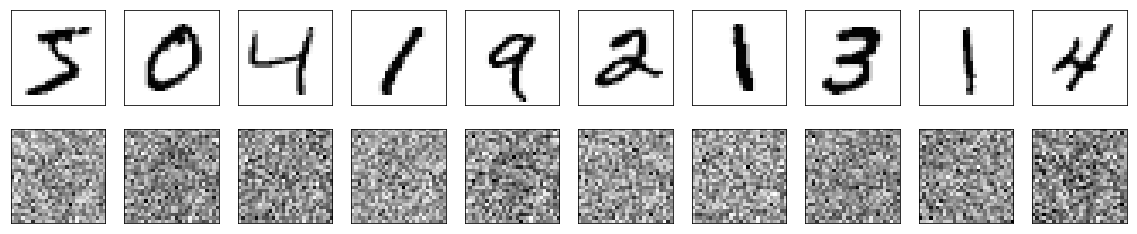

Iteration: 2000 cost: 812.625488
Samples:


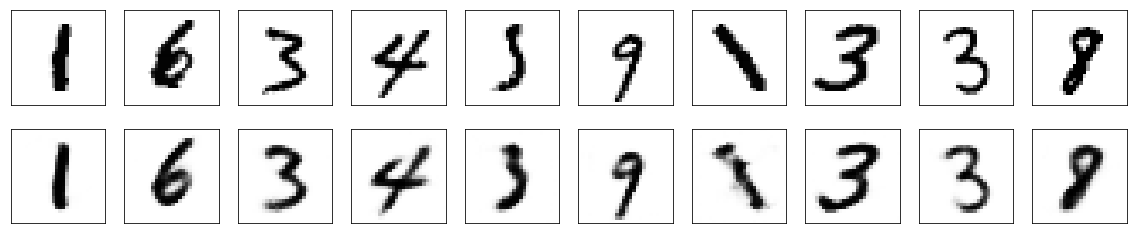

Iteration: 4000 cost: 749.000977
Samples:


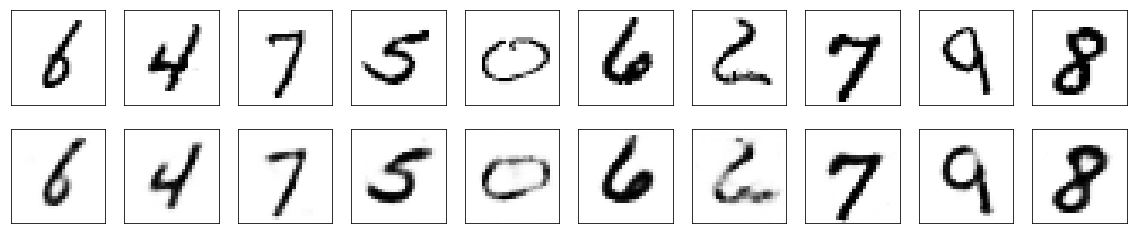

Iteration: 6000 cost: 686.823608
Samples:


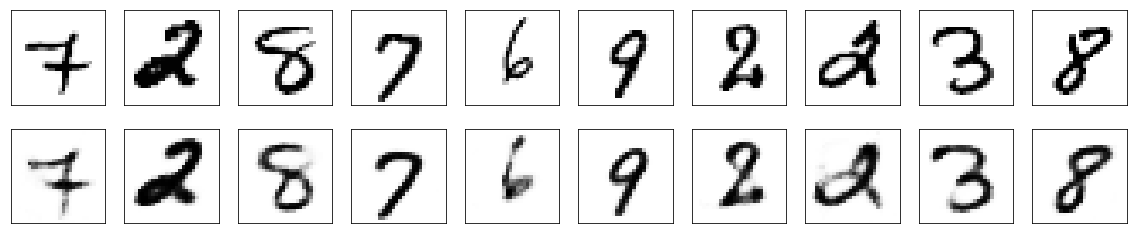

Iteration: 8000 cost: 614.781799
Samples:


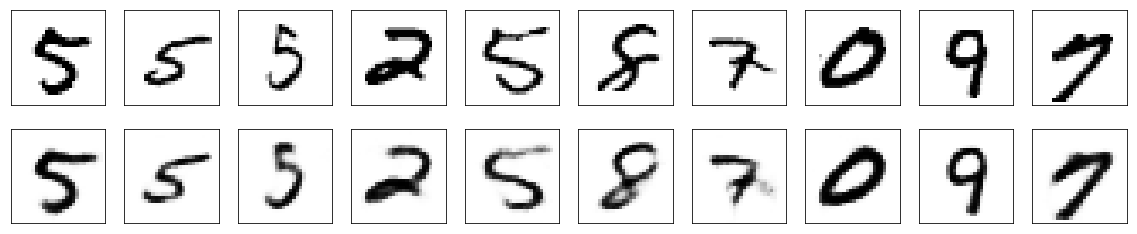

Iteration: 10000 cost: 570.365356
Samples:


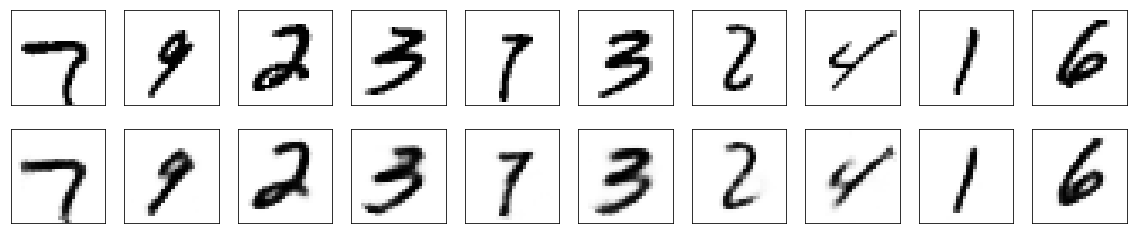

Iteration: 12000 cost: 589.836304
Samples:


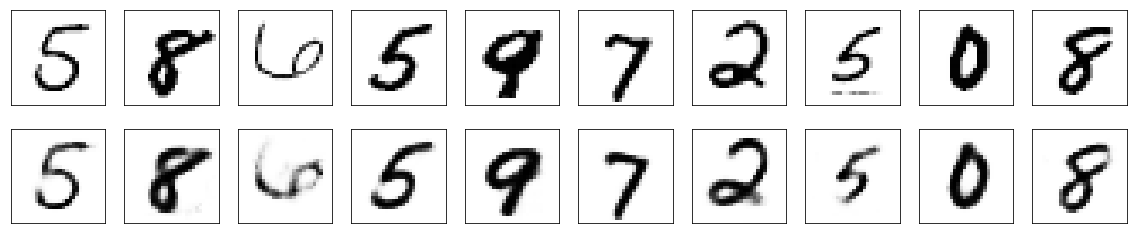

Iteration: 14000 cost: 621.965149
Samples:


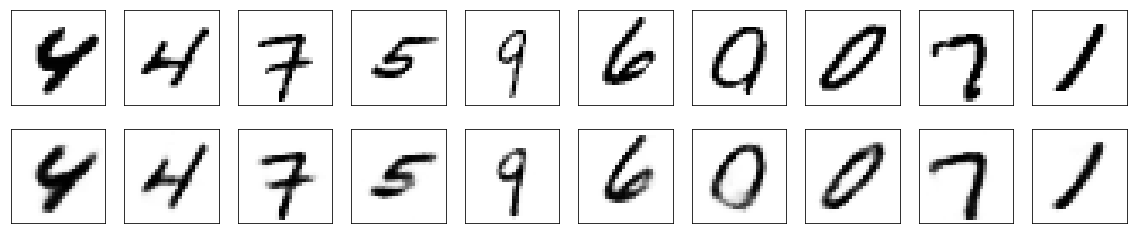

Iteration: 16000 cost: 622.980225
Samples:


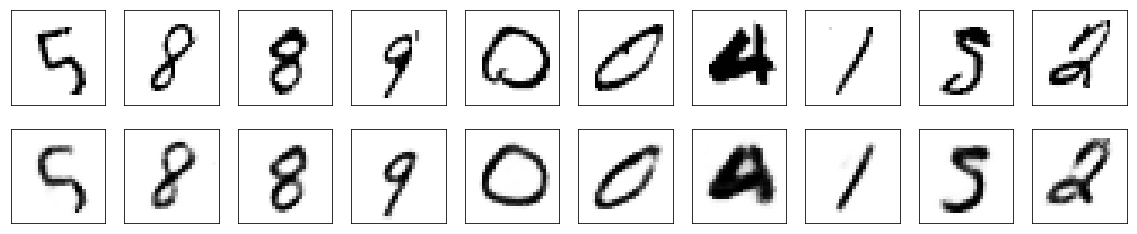

Iteration: 18000 cost: 630.715393
Samples:


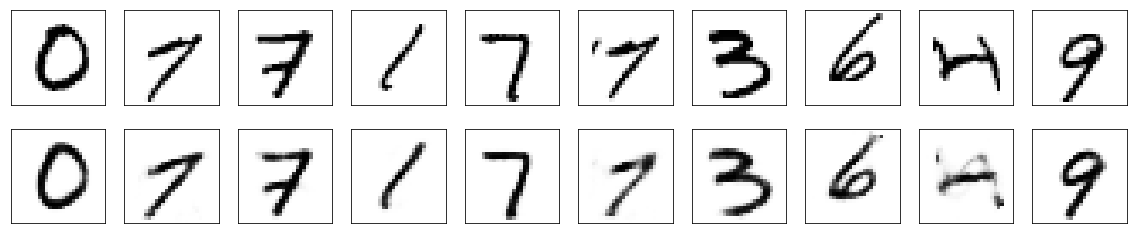

Iteration: 20000 cost: 602.015686
Samples:


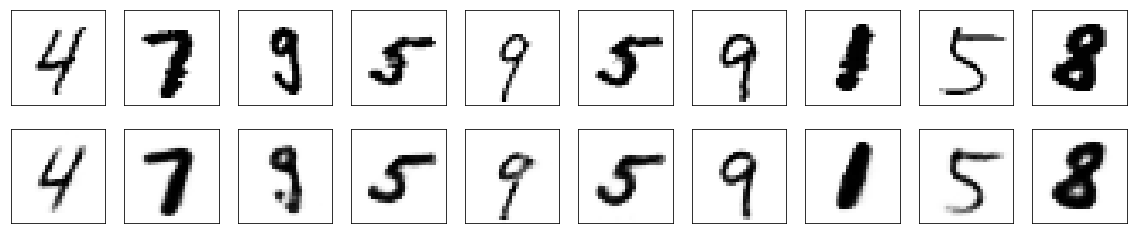

In [16]:
for i in range(20001):
    x, y= mnist.train.next_batch(batch_size)
    input_ = np.concatenate((x, y), axis=1)

    _, c = sess.run([optimizer, cost], feed_dict={x_in: input_, x_: x, label_: y})
    if i % 2000 == 0:
        print("Iteration: %d cost: %f" %(i, c))

        print("Samples:")

        x2, y2 = mnist.validation.next_batch(batch_size)
        test_input = np.concatenate((x2, y2), axis=1)
        feed_dict2 = {x_in: test_input, x_ : x2, label_: y2}
        fetches2 = [reconstruction, cost]
        x_prime2, cost2 = sess.run(fetches2, feed_dict2)
        plotSubset(x2, x_prime2, n=10, name="cv",
                        outdir=plots_outdir)


In [19]:
#conditioning on zero
dig_to_gen = 0
dig_list = np.array([dig_to_gen] * batch_size)
dig_one_hot = np.zeros((batch_size, 10))
dig_one_hot[np.arange(128), dig_list] = 1

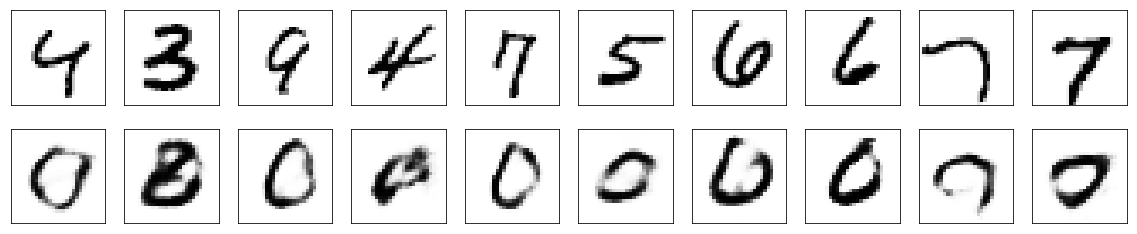

In [18]:
x2, _ = mnist.validation.next_batch(batch_size)
test_input = np.concatenate((x2, y2), axis=1)
feed_dict2 = {x_in: test_input, x_ : x2, label_: dig_one_hot}
fetches2 = [reconstruction, cost]
x_prime2, cost2 = sess.run(fetches2, feed_dict2)
plotSubset(x2, x_prime2, n=10, name="cv",
                outdir=plots_outdir)
